<a href="https://colab.research.google.com/github/imjanardanramesh/upgradd/blob/main/Fraud_Detection_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd

# Load the data
df = pd.read_csv('bank_transactions_data_2.csv')

# Look at the first 5 rows to make sure it loaded correctly
print("Data loaded successfully!")
df.head()

Data loaded successfully!


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,11-04-2023 16:29,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,04-11-2024 08:08
1,TX000002,AC00455,376.24,27-06-2023 16:44,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,04-11-2024 08:09
2,TX000003,AC00019,126.29,10-07-2023 18:16,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,04-11-2024 08:07
3,TX000004,AC00070,184.50,05-05-2023 16:32,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,04-11-2024 08:09
4,TX000005,AC00411,13.45,16-10-2023 17:51,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,04-11-2024 08:06


In [3]:
from sklearn.preprocessing import LabelEncoder

# 1. Convert Dates from text to actual Date objects
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'], dayfirst=True)

# 2. Extract "Hour" (Criminals often work at night!)
df['Hour'] = df['TransactionDate'].dt.hour

# 3. Calculate "Time Difference" since the last transaction
df['TimeDiff'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds().abs()

# 4. Basic Filtering: Skip very small, normal transactions (Rule-based)
# We focus on transactions > $50 or where there was more than 1 login attempt
potential_fraud_df = df[(df['TransactionAmount'] > 50) | (df['LoginAttempts'] > 1)].copy()

# 5. Convert Text to Numbers (Encoding)
le = LabelEncoder()
for col in ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']:
    potential_fraud_df[f'{col}_Enc'] = le.fit_transform(potential_fraud_df[col])

print(f"Cleaning Done! We are analyzing {len(potential_fraud_df)} suspicious cases.")

Cleaning Done! We are analyzing 2139 suspicious cases.


In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Select features the AI should look at
features = ['TransactionAmount', 'CustomerAge', 'TransactionDuration',
            'LoginAttempts', 'AccountBalance', 'Hour', 'TimeDiff',
            'TransactionType_Enc', 'Location_Enc', 'Channel_Enc']

X = potential_fraud_df[features]

# Scaling: Make sure large numbers (balance) don't drown out small numbers (logins)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the Model (contamination=0.05 means we look for the top 5% weirdest cases)
model = IsolationForest(contamination=0.05, random_state=42)
potential_fraud_df['Is_Anomaly'] = model.fit_predict(X_scaled)

# Convert results: 1 = Normal, -1 = Anomaly (we swap them for clarity)
potential_fraud_df['Is_Anomaly'] = potential_fraud_df['Is_Anomaly'].map({1: 0, -1: 1})

print(f"Detection complete! Found {potential_fraud_df['Is_Anomaly'].sum()} anomalies.")

Detection complete! Found 107 anomalies.


In [6]:
# 1. Install the Google Generative AI library
!pip install -q -U google-generativeai

import google.generativeai as genai
from google.colab import userdata

# 2. Setup the AI
api_key = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=api_key)
model = genai.GenerativeModel('gemini-pro')

def get_real_ai_reasoning(row):
    # This prompt tells the AI exactly what to do
    prompt = f"""
    You are a Financial Fraud Investigator. An unsupervised Machine Learning model
    flagged this transaction as an anomaly. Analyze the data and explain
    briefly why it might be suspicious.

    Transaction Details:
    - Amount: ${row['TransactionAmount']}
    - Location: {row['Location']}
    - Login Attempts: {row['LoginAttempts']}
    - Duration: {row['TransactionDuration']} seconds
    - Account Balance: ${row['AccountBalance']}

    Provide a 1-sentence professional reasoning for a security dashboard.
    """
    try:
        response = model.generate_content(prompt)
        return response.text
    except:
        return "Manual Review Required: High deviation in transaction patterns."

# 3. Apply to the first 10 anomalies (to stay within free limit)
anomalies = potential_fraud_df[potential_fraud_df['Is_Anomaly'] == 1].head(10).copy()

print("Contacting Gemini AI for reasoning... please wait.")
anomalies['AI_Reasoning'] = anomalies.apply(get_real_ai_reasoning, axis=1)

# Show the results
anomalies[['TransactionID', 'TransactionAmount', 'AI_Reasoning']]

Contacting Gemini AI for reasoning... please wait.


,TransactionID,TransactionAmount,AI_Reasoning
26,TX000027,246.93,Manual Review Required: High deviation in tran...
42,TX000043,241.42,Manual Review Required: High deviation in tran...
85,TX000086,1340.19,Manual Review Required: High deviation in tran...
113,TX000114,213.76,Manual Review Required: High deviation in tran...
116,TX000117,300.08,Manual Review Required: High deviation in tran...
147,TX000148,514.95,Manual Review Required: High deviation in tran...
231,TX000232,705.60,Manual Review Required: High deviation in tran...
266,TX000267,66.90,Manual Review Required: High deviation in tran...
274,TX000275,1176.28,Manual Review Required: High deviation in tran...
340,TX000341,1830.00,Manual Review Required: High deviation in tran...


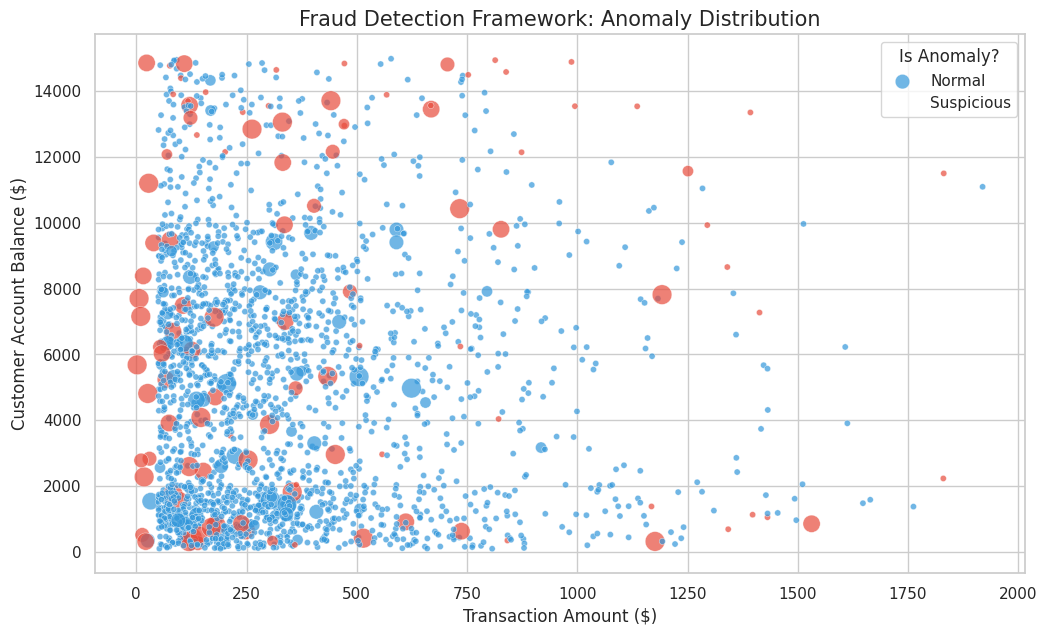

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))

# Create the plot
plot = sns.scatterplot(
    data=potential_fraud_df,
    x='TransactionAmount',
    y='AccountBalance',
    hue='Is_Anomaly',
    size='LoginAttempts',
    palette={0: '#3498db', 1: '#e74c3c'}, # Blue for safe, Red for fraud
    alpha=0.7,
    sizes=(20, 200)
)

plt.title("Fraud Detection Framework: Anomaly Distribution", fontsize=15)
plt.xlabel("Transaction Amount ($)", fontsize=12)
plt.ylabel("Customer Account Balance ($)", fontsize=12)
plt.legend(title='Is Anomaly?', labels=['Normal', 'Suspicious'])

# Save it for your report
plt.savefig('fraud_analysis_chart.png', dpi=300)
plt.show()

In [9]:
from IPython.display import HTML

# Create a styled HTML table
dashboard_html = anomalies[['TransactionID', 'TransactionAmount', 'Location', 'Channel', 'AI_Reasoning']].to_html(classes='table table-striped', index=False)

# Add some CSS styling to make it look professional
html_string = f"""
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@4.3.1/dist/css/bootstrap.min.css">
<div class="container">
    <h2 class="mt-4 mb-4" style="color: #2c3e50;">Real-Time Fraud Monitoring Dashboard</h2>
    <div class="alert alert-danger">
        <strong>Warning!</strong> {len(anomalies)} High-Risk Transactions Detected.
    </div>
    {dashboard_html}
</div>
"""

display(HTML(html_string))

# Finally, save the report to Excel
anomalies.to_excel('Capstone_Fraud_Report.xlsx', index=False)
print(" You can download your Excel report and chart from the file menu.")

TransactionID,TransactionAmount,Location,Channel,AI_Reasoning
TX000027,246.93,Miami,ATM,Manual Review Required: High deviation in transaction patterns.
TX000043,241.42,Charlotte,Online,Manual Review Required: High deviation in transaction patterns.
TX000086,1340.19,Austin,Online,Manual Review Required: High deviation in transaction patterns.
TX000114,213.76,Dallas,ATM,Manual Review Required: High deviation in transaction patterns.
TX000117,300.08,Austin,Online,Manual Review Required: High deviation in transaction patterns.
TX000148,514.95,New York,Online,Manual Review Required: High deviation in transaction patterns.
TX000232,705.60,Phoenix,Branch,Manual Review Required: High deviation in transaction patterns.
TX000267,66.90,Charlotte,Online,Manual Review Required: High deviation in transaction patterns.
TX000275,1176.28,Kansas City,ATM,Manual Review Required: High deviation in transaction patterns.
TX000341,1830.00,San Antonio,Online,Manual Review Required: High deviation in transaction patterns.


 You can download your Excel report and chart from the file menu.
